**NOTE!** The code uses processed data from the LHCb experiment. Collaboration members please write nikita.kazeev@cern.ch for access.

In [1]:
from deep_ensembles import nets, data
from deep_ensembles.params import *
from deep_ensembles.train import train, repeater, ParticleSet
#from deep_ensembles.eval import count_model_accuracy, count_uncertainty, eval_model_by_classifier, eval_model_by_ks

## Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/lhcb'
import os
import numpy as np

def get_particle_dset(particle):
    return [os.path.join(data_dir, name) for name in os.listdir(data_dir) if particle in name]

datasets = {particle: get_particle_dset(particle) for particle in PARTICLES} 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
_, _, _, data_train_s, data_val_s, data_test_s, scaler = data.get_val_dataset(datasets, PARTICLE_TYPE, dtype=np.float32, log=True)

**Define thresholds** 

In [72]:
PARTICLES = ['kaon', 'pion', 'proton', 'muon', 'electron']

dlls = np.array(data_train_s)[:, :len(PARTICLES)]
thr = [np.percentile(dlls[:, i], 10) for d in range(len(PARTICLES))]

**Load models**

In [13]:
import torch
import matplotlib.pyplot as plt 

y_count = 5
num_models = 10
NUM_LAYERS = 5
device = 'cuda'
models_path = '/content/drive/MyDrive/lhcb/rich_new/generators_without_weights.pt'

netGs = nets.GeneratorEnsemble(num_models=num_models, depth=NUM_LAYERS).to(device)
netGs.load_state_dict(torch.load(models_path, map_location=torch.device(device))['model_state_dict'])
netGs.eval()

GeneratorEnsemble(
  (Gmodel_0): Generator(
    (layers): Sequential(
      (0): Linear(in_features=67, out_features=128, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (3): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (4): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (5): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (6): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (7): Linear(in_features=128, out_features=5, bias=True)
    )
  )
  (Gmodel_1): Generator(
    (layers): Sequential(
      (0): Linear(in_features=67, out_features=128, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Linear(in_features=128, 

In [14]:
def conditional_gan(x, trues=None, i=None):
  if i is not None:
    model = getattr(netGs, 'Gmodel_' + str(i))
    return model(torch.tensor(x).to(device)).cpu().detach().numpy()
  _, _, preds = netGs(torch.tensor(x).to(device))
  if trues is not None:
    assert(preds.shape[1] == len(trues))
  
  return preds.cpu().detach().numpy()


## Uncertainty prediction

In [74]:
X = []
st = []
stsy = []
ref_i = 0
condition_dataset = np.array(data_val_s)[:, y_count:-1]

for i in range(num_models):
  X.append (condition_dataset)
  st.append (conditional_gan(condition_dataset, i=ref_i) - conditional_gan(condition_dataset, i=ref_i))
  stsy.append (conditional_gan(condition_dataset, i=i) - conditional_gan(condition_dataset, i=ref_i))

X = np.concatenate(X)
st = np.concatenate(st)
stsy = np.concatenate(stsy)


In [75]:
def prepare(dset, i=0, j=1):
  d1 = dset.T[i]
  d2 = dset.T[j]
  return np.c_ [np.square(d1), d1*d2, np.square(d2)]

n = len(X)

index = np.random.permutation(n)
X = X[index]
Y1 = prepare(st[index])
Y2 = prepare(stsy[index])

In [94]:
from sklearn.ensemble import RandomForestRegressor as RF
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)  
        self.predict = torch.nn.Linear(n_hidden, n_output)  

    def forward(self, x):
        x = F.relu(self.hidden(x)) 
        x = self.predict(x)   
        return x

def train_models(X, Y1, Y2, mode='rf'):
  assert(mode in ('rf', 'nn'))
  model1, model2 = None, None
  if mode == 'rf':
    model1 = RF(max_depth=3)
    model2 = RF(max_depth=3)

    N = 500000
    model1.fit(np.c_[X[:N]], Y1[:N])
    model2.fit(np.c_[X[:N]], Y2[:N])
  
  else:    
    model1 = Net(n_feature=3, n_hidden=32, n_output=2)    
    model2 = Net(n_feature=3, n_hidden=32, n_output=2)    
    for model in [model1, model2]:
      optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
      loss_func = torch.nn.MSELoss()  
      for t in range(300):
        pred = model(torch.tensor(x)) 
        loss = loss_func(pred, y)  
        optimizer.zero_grad()
        loss.backward()   
        optimizer.step()   

  return model1, model2

In [ ]:
model1, model2 = train_models(X, Y1, Y2, mode='rf')

## Plot efficiency

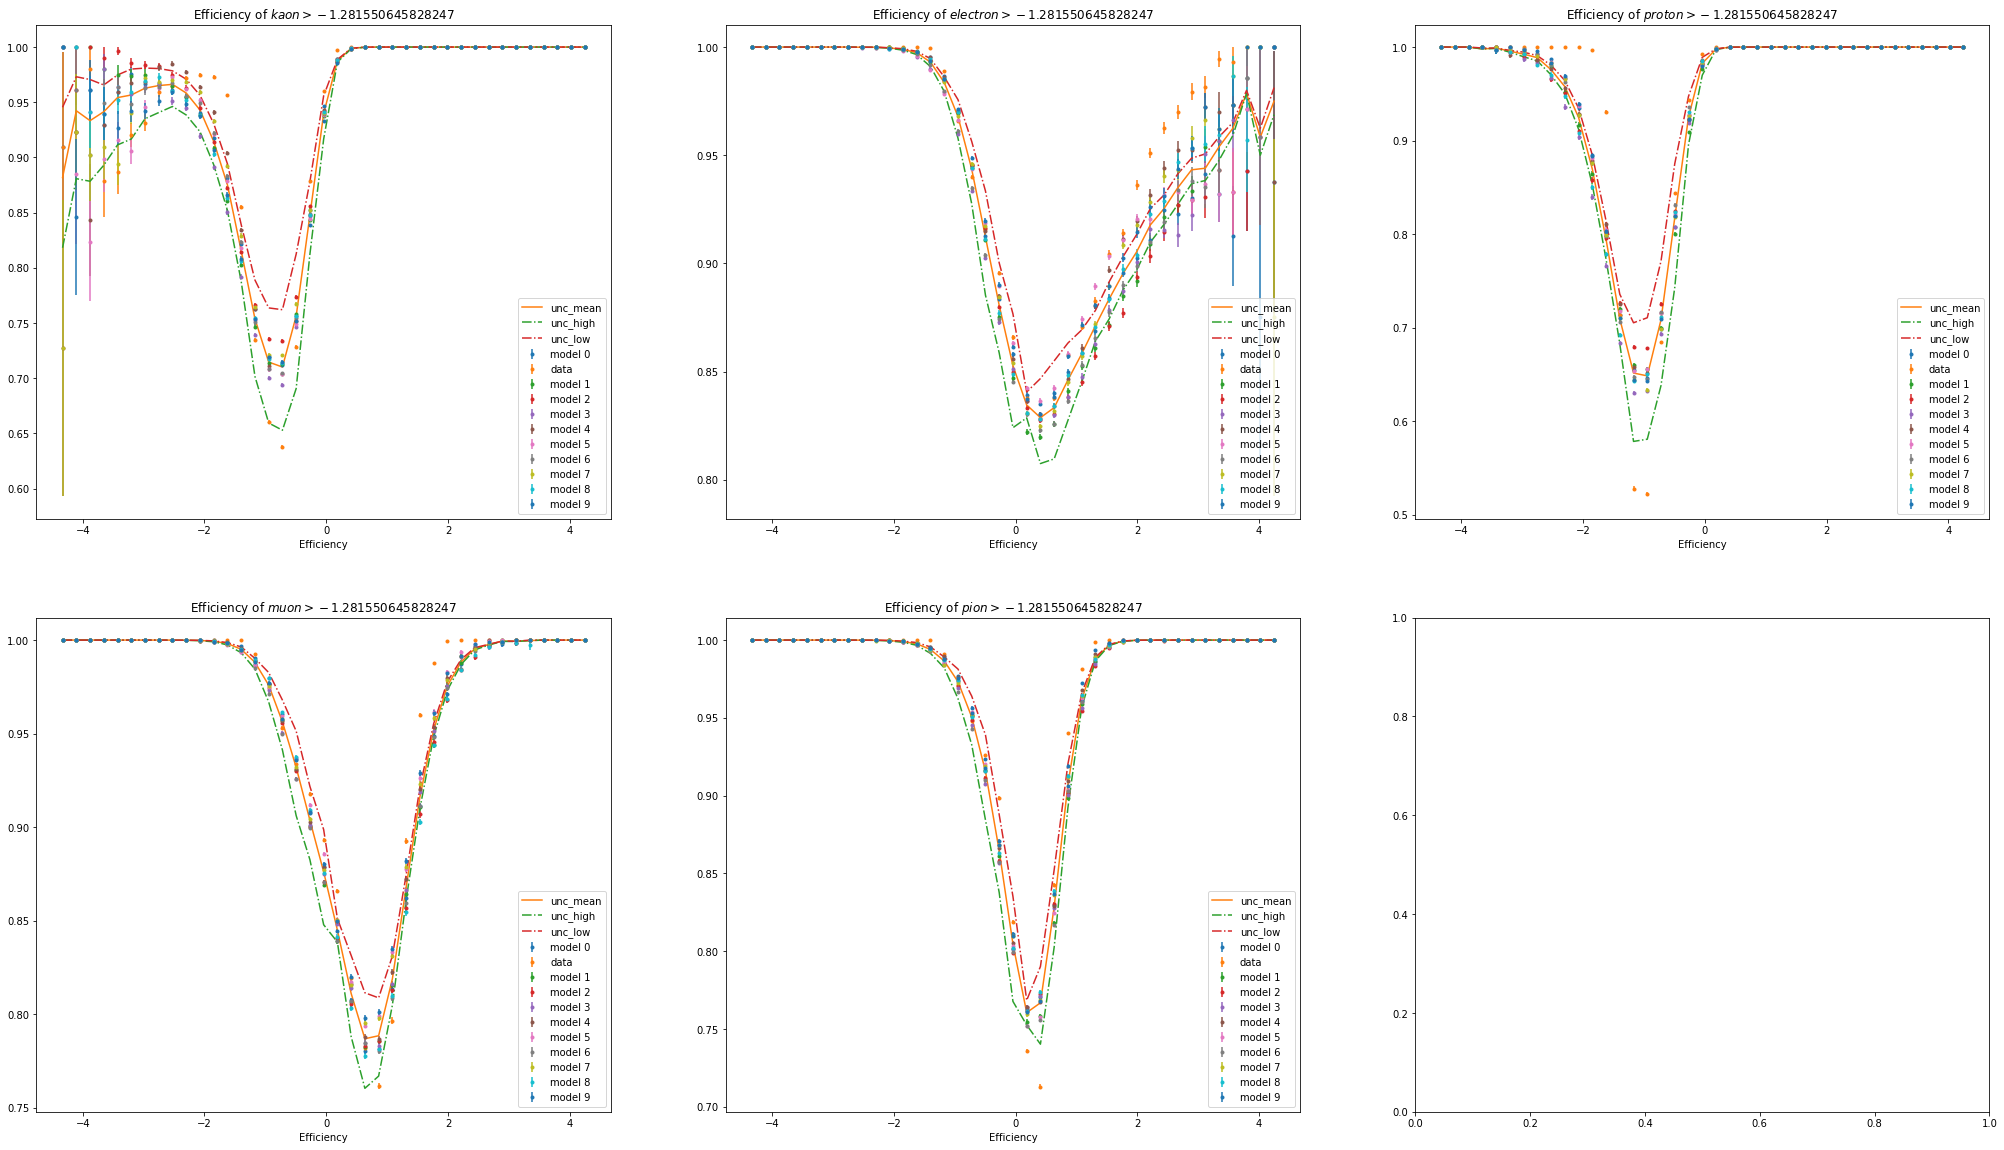

In [80]:
condition_dataset = np.array(data_val_s)
x_boundaries = np.linspace(min(condition_dataset[:, y_count]), max(condition_dataset[:, y_count]), 40)
fig, ax = plt.subplots(2, 3, figsize=(35, 20))

for i in range(len(PARTICLES)):
  for j in range(num_models):
    eff = []
    err = []
    data_eff = []
    data_err = []
    for xmin, xmax in zip(x_boundaries[:-1], x_boundaries[1:]):
      mask = (condition_dataset[:, y_count] > xmin) & (condition_dataset[:, y_count] < xmax)
      if not np.count_nonzero(mask):
        eff.append(0.5)
        data_eff.append(0.5)
        err.append(0.5)
        data_err.append(0.5)
        continue
      trues = condition_dataset[mask][:, :y_count][:, i]
      ys = conditional_gan(condition_dataset[mask][:, y_count:-1], trues)[:, :, i]
      ys = ys[j]

      eff.append (np.count_nonzero(ys > thr[i])/len(ys))
      err.append (np.sqrt ( np.count_nonzero(ys>thr[i])*np.count_nonzero(ys<thr[i])/(len(ys)**3)))
      if j == 0:
        data_eff.append (np.count_nonzero(trues > thr[i])/len(trues))
        data_err.append (np.sqrt ( np.count_nonzero(trues>thr[i])*np.count_nonzero(trues<thr[i])/(len(trues)**3)))

    x = 0.5 * (x_boundaries[1:]+x_boundaries[:-1])
    ax[i % 2][i % 3].errorbar ( x, eff, np.asarray(err), fmt='.', label=f'model {j}')
    if j == 0:
      ax[i % 2][i % 3].errorbar ( x, data_eff, np.asarray(data_err), fmt='.', label='data')

  xvalue = []
  eff_mean = []
  eff_high = []
  eff_low = []
  for xmin, xmax in zip(x_boundaries[:-1], x_boundaries[1:]):
      mask = (condition_dataset[:, y_count] > xmin) & (condition_dataset[:, y_count] < xmax)
      if np.count_nonzero(mask):
        ys = conditional_gan(condition_dataset[mask][:, y_count:-1], None)[:, :, i]        
        xvalue.append (0.5*(xmin + xmax))
        uncert = np.sqrt(np.maximum(0, model2.predict(np.c_[condition_dataset[mask][:, y_count:-1]])/2 - model1.predict(np.c_[condition_dataset[mask][:, y_count:-1]])/2))
        n = np.count_nonzero(mask) * num_models
        eff_mean.append (np.count_nonzero(ys > thr[i])/n)
        eff_low.append (np.count_nonzero(ys + uncert[:,0] > thr[i])/n)
        eff_high.append (np.count_nonzero(ys - uncert[:,0] > thr[i])/n)

  ax[i % 2][i % 3].plot (xvalue, eff_mean, '-', label=f'unc_mean')
  ax[i % 2][i % 3].plot (xvalue, eff_high, '-.', label=f'unc_high')
  ax[i % 2][i % 3].plot (xvalue, eff_low, '-.', label=f'unc_low')

  #ax[i].savefig(f'{PARTICLES[i]}.png', bbox_inches='tight')
  ax[i % 2][i % 3].title.set_text(f"Efficiency of ${PARTICLES[i]} > {thr[i]}$")
  ax[i % 2][i % 3].legend(loc='lower right')
  ax[i % 2][i % 3].set_xlabel("Momentum")
  ax[i % 2][i % 3].set_xlabel("Efficiency")
plt.show()


